In [1]:
from numpy import array, sqrt
from filterpy.kalman import ExtendedKalmanFilter as EKF
from sympy import Symbol, symbols, Matrix, sin, cos
from filterpy.stats import plot_covariance_ellipse
from filterpy.common import Saver
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter
from sympy import init_printing
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy.random import randn
pd.set_option('display.max_columns', 50)

init_printing(use_latex=True)


## Situtation Covered Breif Explanation
1. Velocity sensor is there,measures speed in heading direction
2. YawRate sensor
3. Position information from a GPS sensor (x,y)
4. Thus the measurement state is four [x,y,velocity,yawrate].
5. The state of the kalman is five [x,y,yaw,velocity,yawrate].
6. The motion model while travelling straight and while turning is different , and thus the jacobians will also note. 
7. The gps measurements are not available in all the cycles thus the jacobian of the measurement  calculated will change for those cycles in which GPS is available and those without GPS.
8. Implementation detail of motion models and jacobians-> here i have used sympy and used the evalf method available so i didnt need to type in the jacobains( execution is slow though).

In [2]:
numstates=5 # States
dt = 1.0/50.0 # Sample Rate of the Measurements is 50Hz
dtGPS=1.0/10.0 # Sample Rate of GPS is 10Hz

In [3]:
vs, psis, dpsis, dts, xs, ys, lats, lons = symbols('v \psi \dot\psi T x y lat lon')

gs = Matrix([[xs+(vs/dpsis)*(sin(psis+dpsis*dts)-sin(psis))],
             [ys+(vs/dpsis)*(-cos(psis+dpsis*dts)+cos(psis))],
             [psis+dpsis*dts],
             [vs],
             [dpsis]])
state = Matrix([xs,ys,psis,vs,dpsis])

In [4]:
gs

⎡    v⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi))⎤
⎢x + ───────────────────────────────────────⎥
⎢                    \dot\psi               ⎥
⎢                                           ⎥
⎢    v⋅(cos(\psi) - cos(T⋅\dot\psi + \psi)) ⎥
⎢y + ────────────────────────────────────── ⎥
⎢                   \dot\psi                ⎥
⎢                                           ⎥
⎢             T⋅\dot\psi + \psi             ⎥
⎢                                           ⎥
⎢                     v                     ⎥
⎢                                           ⎥
⎣                 \dot\psi                  ⎦

In [5]:
state

⎡   x    ⎤
⎢        ⎥
⎢   y    ⎥
⎢        ⎥
⎢  \psi  ⎥
⎢        ⎥
⎢   v    ⎥
⎢        ⎥
⎣\dot\psi⎦

In [6]:
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0, 1000.0])
print(P, P.shape)

[[1000.    0.    0.    0.    0.]
 [   0. 1000.    0.    0.    0.]
 [   0.    0. 1000.    0.    0.]
 [   0.    0.    0. 1000.    0.]
 [   0.    0.    0.    0. 1000.]] (5, 5)


### Process Noise

In [7]:
sGPS     = 0.5*8.8*dt**2  # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
sCourse  = 0.1*dt # assume 0.1rad/s as maximum turn rate for the vehicle
sVelocity= 8.8*dt # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
sYaw     = 1.0*dt # assume 1.0rad/s2 as the maximum turn rate acceleration for the vehicle

Q = np.diag([sGPS**2, sGPS**2, sCourse**2, sVelocity**2, sYaw**2])
print(Q, Q.shape)

[[3.0976e-06 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 3.0976e-06 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 4.0000e-06 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 3.0976e-02 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e-04]] (5, 5)


<AxesSubplot:>

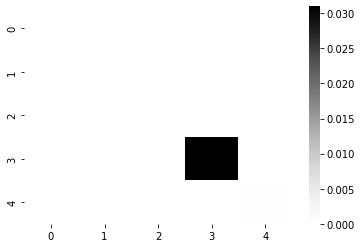

In [8]:
sns.heatmap(Q,cmap='Greys')

### Reading in data 

In [9]:
datafile = '../Data/2014-03-26-000-Data.csv'
df = pd.read_csv(datafile)

In [10]:
df.head()

,date,time,millis,ax,ay,az,rollrate,pitchrate,yawrate,roll,pitch,yaw,speed,course,latitude,longitude,altitude,pdop,hdop,vdop,epe,fix,satellites_view,satellites_used,temp
0,260314,123825300,1.395838e+12,0.2647,-0.6570,-9.3843,2.7130,0.5565,-18.7130,1.8097,3.3195,-41.8803,2.42,324.20,51.039553,13.792498,111.52,2.54,2.35,0.96,4.4,3,7,5,43.6
1,260314,123825300,1.395838e+12,-0.7158,-0.7844,-9.6099,2.2956,-3.0608,-17.7391,2.0463,3.2085,-42.0175,2.45,329.62,51.039553,13.792498,111.52,2.54,2.35,0.96,4.4,3,7,5,43.6
2,260314,123825400,1.395838e+12,-1.6964,-0.3628,-10.7670,1.8086,-4.5913,-16.5565,2.2435,3.0770,-42.1223,2.45,329.62,51.039553,13.792498,111.52,2.54,2.35,0.96,4.4,3,7,5,43.6
3,260314,123825400,1.395838e+12,-0.2843,-1.1865,-9.3843,2.7130,0.6260,-15.4434,2.4332,2.9835,-42.1991,2.45,329.62,51.039553,13.792498,111.52,2.54,2.35,0.96,4.4,3,7,5,43.6
4,260314,123825400,1.395838e+12,0.2059,-0.3137,-7.6683,2.8521,0.3478,-15.0260,2.6337,2.8762,-42.2685,2.45,329.62,51.039553,13.792498,111.52,2.54,2.35,0.96,4.4,3,7,5,43.6


In [11]:
df.shape

In [12]:
df.keys()

Index(['date', 'time', 'millis', 'ax', 'ay', 'az', 'rollrate', 'pitchrate',
       'yawrate', 'roll', 'pitch', 'yaw', 'speed', 'course', 'latitude',
       'longitude', 'altitude', 'pdop', 'hdop', 'vdop', 'epe', 'fix',
       'satellites_view', 'satellites_used', 'temp'],
      dtype='object')

In [13]:
altitude = df['altitude'].values
latitude = df['latitude'].values
longitude = df['longitude'].values
course  = df['course'].values
speed = df['speed'].values
yawrate  = df['yawrate'].values
# A course of 0° means the Car is traveling north bound
# and 90° means it is traveling east bound.
# In the Calculation following, East is Zero and North is 90°
# We need an offset.
course =(-course+90.0)

## Measurement Function

In [14]:
#  we have four measurement states
hs = Matrix([[xs],
             [ys],
             [vs],
             [dpsis]])
hs

⎡   x    ⎤
⎢        ⎥
⎢   y    ⎥
⎢        ⎥
⎢   v    ⎥
⎢        ⎥
⎣\dot\psi⎦

In [15]:
JHs=hs.jacobian(state)
JHs

⎡1  0  0  0  0⎤
⎢             ⎥
⎢0  1  0  0  0⎥
⎢             ⎥
⎢0  0  0  1  0⎥
⎢             ⎥
⎣0  0  0  0  1⎦

In [16]:
varGPS = 6.0 # Standard Deviation of GPS Measurement
varspeed = 1.0 # Variance of the speed measurement
varyaw = 0.1 # Variance of the yawrate measurement
R = np.matrix([[varGPS**2, 0.0, 0.0, 0.0],
               [0.0, varGPS**2, 0.0, 0.0],
               [0.0, 0.0, varspeed**2, 0.0],
               [0.0, 0.0, 0.0, varyaw**2]])

print(R, R.shape)

[[3.6e+01 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 3.6e+01 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 1.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 1.0e-02]] (4, 4)


<AxesSubplot:>

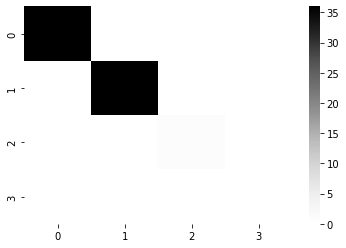

In [17]:
sns.heatmap(R,cmap='Greys')

### Lat lon to meters to check Location

In [18]:
RadiusEarth = 6378388.0 # m
#this line tells us about the meters per degree
arc= 2.0*np.pi*(RadiusEarth+altitude)/360.0 # m/°

dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m

mx = np.cumsum(dx)
my = np.cumsum(dy)

ds = np.sqrt(dx**2+dy**2)

GPS=(ds!=0.0).astype('bool') # GPS Trigger for Kalman Filter

In [19]:
measurements = np.vstack((mx, my, speed/3.6, yawrate/180.0*np.pi))
# Lenth of the measurement
m = measurements.shape[1]
print(measurements.shape)

(4, 10800)


[[ 0.        ]
 [ 0.        ]
 [-4.08756111]
 [ 0.67322222]
 [-0.32660346]] (5, 1)


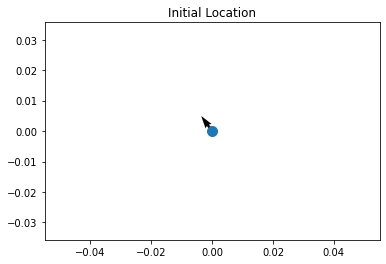

In [20]:
#In other words, the value in km/h divide by 3.6 to get a value in m/s.
x = np.matrix([[mx[0], my[0], course[0]/180.0*np.pi, speed[0]/3.6+0.001, yawrate[0]/180.0*np.pi]]).T
print(x, x.shape)

U=float(np.cos(x[2])*x[3])
V=float(np.sin(x[2])*x[3])

plt.quiver(x[0], x[1], U, V)
plt.scatter(float(x[0]), float(x[1]), s=100)
plt.title('Initial Location')
plt.axis('equal')

In [21]:
from filterpy.kalman import ExtendedKalmanFilter as EKF
from numpy import array,sqrt

# def normalize(x):
#     temp = val + np.pi
#     temp = temp%(2.0*np.pi)
#     temp = temp - np.pi
#     return temp

# Normalize the angle between [-pi to pi]
def normalize(x):
    temp = x%(2.0*np.pi) # force in range [0, 2 pi)
    if  temp>np.pi: # move to [-pi, pi)
        temp -= 2*np.pi
    return temp

In [22]:

class RoboEKF(EKF):
    def __init__(self, dt, Q, x_initial):
        EKF.__init__(self, 5, 4)
        self.dt = dt
        self.x = x_initial

        vs, psis, dpsis, dts, xs, ys, lats, lons = symbols(
            'v \psi \dot\psi T x y lat lon')
        self.F = Matrix([[xs+(vs/dpsis)*(sin(psis+dpsis*dts)-sin(psis))],
                         [ys+(vs/dpsis)*(-cos(psis+dpsis*dts)+cos(psis))],
                         [psis+dpsis*dts],
                         [vs],
                         [dpsis]])
        self.F_straight = Matrix([[xs + vs*dts*(cos(psis))],
                                  [ys + vs*dts*(sin(psis))],
                                  [psis],
                                  [vs],
                                  [0.0000001]])
        self.state = Matrix([xs, ys, psis, vs, dpsis])
        self.F_J = self.F.jacobian(self.state)
        self.F_j_straight = self.F_straight.jacobian(self.state)
        self.subs = {vs: 0, psis: 0, dpsis: 0, dts: 0, xs: 0, ys: 0}

        self.x_s, self.y_s, self.time = xs, ys, dts
        self.v_s, self._psis, self._dpsis = vs, psis, dpsis
        self.Q = Q

        # initialize subs with the initial values
        self.subs[self.x_s] = self.x[0, 0]
        self.subs[self.y_s] = self.x[1, 0]
        self.subs[self._psis] = self.x[2, 0]
        self.subs[self.v_s] = self.x[3, 0]
        self.subs[self._dpsis] = self.x[4, 0]
        self.subs[self.time] = self.dt

    def predict(self, yawrate):
        # we should put it at first because we need to evaluate he move from the previous step with the the self.subs
        self.subs[self.x_s] = self.x[0, 0]
        self.subs[self.y_s] = self.x[1, 0]
        self.subs[self._psis] = self.x[2, 0]
        self.subs[self.v_s] = self.x[3, 0]
        self.subs[self._dpsis] = self.x[4, 0]

        self.x = self.move(yawrate)
        # print(self.x)
        # if we want to calculate the jacobian at the predicted state we should calculate the jacobian at this point.
        # to do that we should re-substitute s with self.subs

        if np.abs(yawrate) < 0.0001:  # Driving straight
            print("driving straight")
            F = np.array(self.F_j_straight.evalf(subs=self.subs)).astype(float)
            self.calculatedJacobian = F

        else:
            F = np.array(self.F_J.evalf(subs=self.subs)).astype(float)
            self.calculatedJacobian = F

        self.P = F@self.P@F.T + self.Q

    def move(self, yawrate):
        if np.abs(yawrate) < 0.0001:  # Driving straight
            print("driving straight")
            x_t = np.array(self.F_straight.evalf(subs=self.subs)).astype(float)
            x_t[2, 0] = normalize(x_t[2, 0])
        else:
            x_t = np.array(self.F.evalf(subs=self.subs)).astype(float)
            x_t[2, 0] = normalize(x_t[2, 0])
        # print(x_t)
        return x_t



In [23]:
#first argument is always the state eventhough it might be not used
# this is because this is being called internally in the update routine and
# self.x is the first argument

def H_of(x, filterStep):
    if GPS[filterStep]:  # with 10Hz, every 5th step
        print("GPS update")
        JH = np.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0, 0.0, 0.0],
                       [0.0, 0.0, 0.0, 1.0, 0.0],
                       [0.0, 0.0, 0.0, 0.0, 1.0]])
    else:  # every other step
        JH = np.array([[0.0, 0.0, 0.0, 0.0, 0.0],
                       [0.0, 0.0, 0.0, 0.0, 0.0],
                       [0.0, 0.0, 0.0, 1.0, 0.0],
                       [0.0, 0.0, 0.0, 0.0, 1.0]])

    return JH


# first argument is always the state eventhough it might be not used
# this is because this is being called internally in the update routine and
# self.x is the first argument
def Hx(x):
    hx = np.array([[float(x[0])],
                   [float(x[1])],
                   [float(x[3])],
                   [float(x[4])]])
    return hx


In [24]:

noOfMeasurements = measurements.shape[1]
ekf = RoboEKF(dt=0.02, Q=Q, x_initial=x)
s = Saver(ekf)
ekf.P = P
ekf.R = R

for filterstep in range(noOfMeasurements):
    yawRateCurrent = yawrate[filterstep]
    # for prediction yaw rate is required since we
    # need to differentiatte between if we are driving straight or not
    ekf.predict(yawRateCurrent)

    z = measurements[:, filterstep].reshape(-1, 1)

    # filter step is need as an argumenet for jacoabian calculation
    # so we can see if GPS measurement was available or not
    # and return the H_jacob accordingly
    ekf.update(z, HJacobian=H_of, Hx=Hx, args=filterstep)
    #print(f"FilterStep = {filterstep} \n", ekf.x)
    #print()
    s.save()

GPS update
GPS update
GPS update
driving straight
driving straight
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
driving straight
driving straight
GPS update
driving straight
driving straight
driving straight
driving straight
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
driving straight
driving straight
GPS update
driving straight
driving straight
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
driving straight
driving straight
GPS update
driving straight
driving straight
driving straight
driving straight
driving straight
driving straight
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
driving straight
driving straight
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
GPS update
driving straight
driving straigh

In [25]:
filterstep

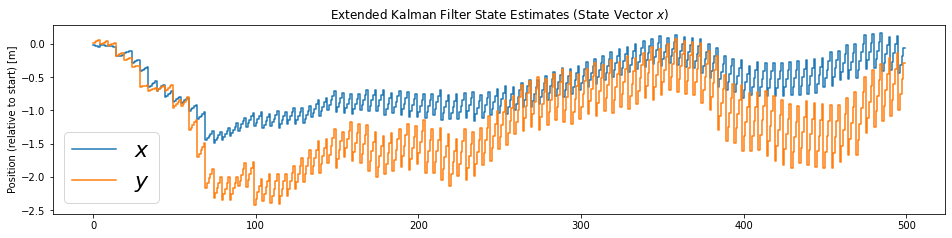

In [26]:
outStates = np.array(s.x)
def plotx():
    fig = plt.figure(figsize=(16,16))

    plt.subplot(411)
    plt.step(range(500),outStates[:500,0,0]-measurements[0,:500], label='$x$')
    plt.step(range(500),outStates[:500,1,0]-measurements[1,:500], label='$y$')

    plt.title('Extended Kalman Filter State Estimates (State Vector $x$)')
    plt.legend(loc='best',prop={'size':22})
    plt.ylabel('Position (relative to start) [m]')

    
plotx()

In [29]:
outStates = np.array(s.x)
def plotx():
    fig = plt.figure(figsize=(16,16))

    plt.subplot(411)
    plt.step(range(len(measurements[0])),outStates[:,0,0]-mx[0], label='$x$')
    plt.step(range(len(measurements[0])),outStates[:,1,0]-my[0], label='$y$')

    plt.title('Extended Kalman Filter State Estimates (State Vector $x$)')
    plt.legend(loc='best',prop={'size':22})
    plt.ylabel('Position (relative to start) [m]')

    plt.subplot(412)
    plt.step(range(len(measurements[0])),outStates[:,2,0], label='$\psi$')
    plt.step(range(len(measurements[0])),(course/180.0*np.pi+np.pi)%(2.0*np.pi) - np.pi, label='$\psi$ (from GPS as reference)')
    plt.ylabel('Course')
    plt.legend(loc='best',prop={'size':16})

    plt.subplot(413)
    plt.step(range(len(measurements[0])),outStates[:,3,0], label='$v$')
    plt.step(range(len(measurements[0])),speed/3.6, label='$v$ (from GPS as reference)')
    plt.ylabel('Velocity')
    plt.ylim([0, 30])
    plt.legend(loc='best',prop={'size':16})

    plt.subplot(414)
    plt.step(range(len(measurements[0])),outStates[:,4,0], label='$\dot \psi$')
    plt.step(range(len(measurements[0])),yawrate/180.0*np.pi, label='$\dot \psi$ (from IMU as reference)')
    plt.ylabel('Yaw Rate')
    plt.ylim([-0.6, 0.6])
    plt.legend(loc='best',prop={'size':16})
    plt.xlabel('Filter Step')

    plt.savefig('Extended-Kalman-Filter-CTRV-State-Estimates.png', dpi=72, transparent=True, bbox_inches='tight')

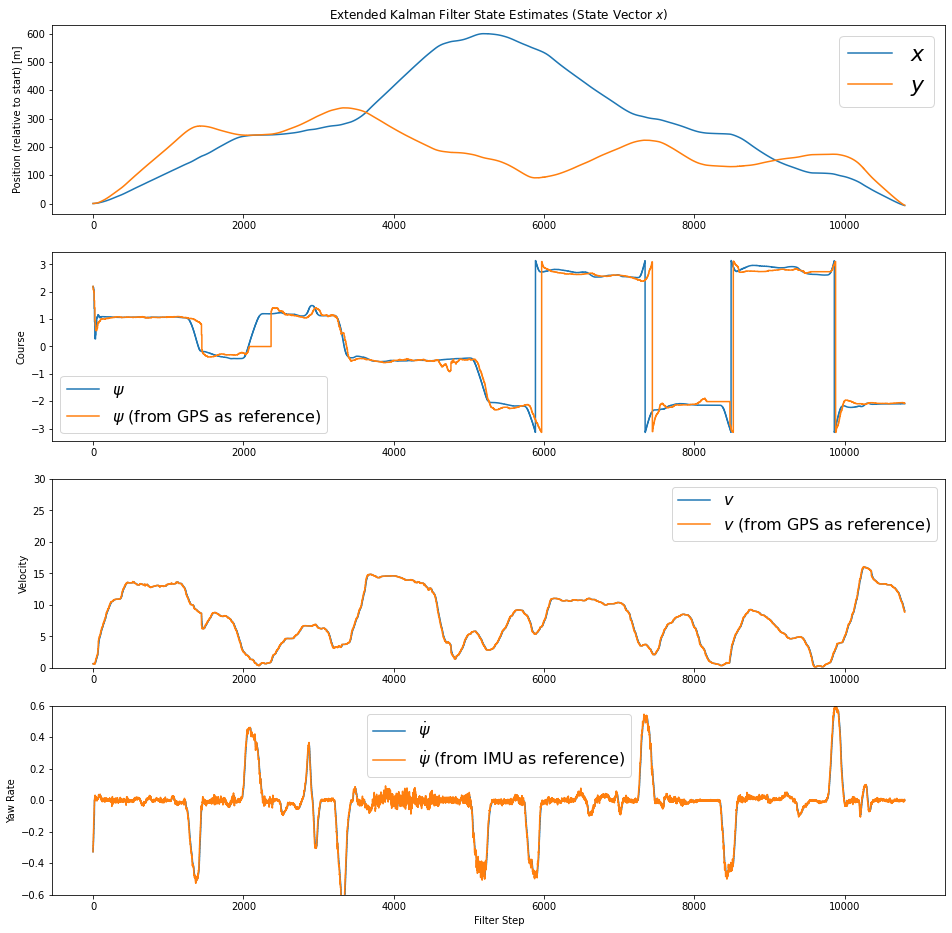

In [30]:
plotx()

In [31]:
covMatrix = np.array(s.P)
def plotP(covMatrix):
    fig = plt.figure(figsize=(16,9))
    plt.semilogy(range(m),covMatrix[:,0,0], label='$x$')
    plt.step(range(m),covMatrix[:,1,1], label='$y$')
    plt.step(range(m),covMatrix[:,2,2], label='$\psi$')
    plt.step(range(m),covMatrix[:,3,3], label='$v$')
    plt.step(range(m),covMatrix[:,4,4], label='$\dot \psi$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Uncertainty (Elements from Matrix $P$)')
    plt.legend(loc='best',prop={'size':22})

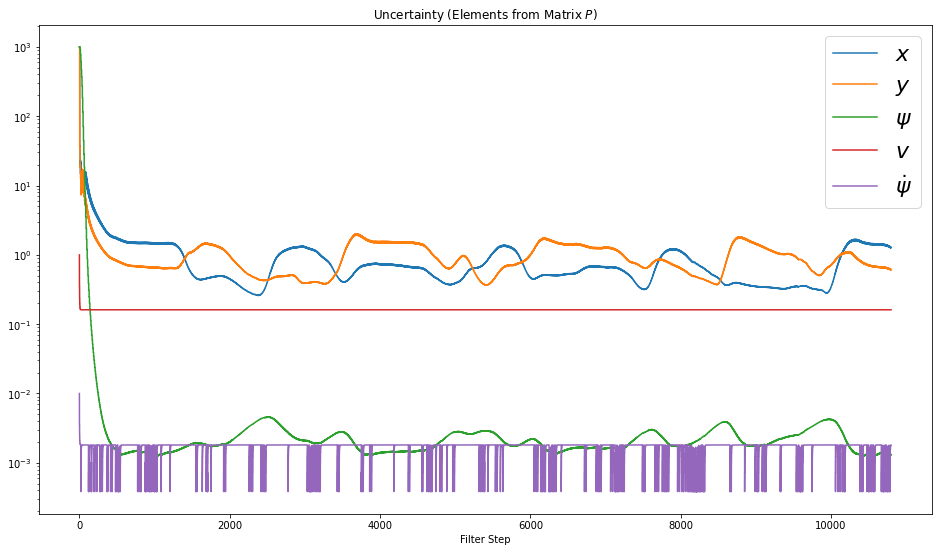

In [32]:
plotP(covMatrix)

<AxesSubplot:>

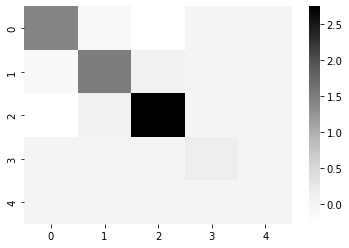

In [33]:
summed = np.sum(covMatrix,axis=0)/covMatrix.shape[0]
sns.heatmap(summed,cmap='Greys')

### Position x/y

In [34]:
STATES = np.array(s.x)

In [35]:
STATES.shape

In [36]:
x0 = STATES[:,0,0]
x1 = STATES[:,1,0]
x2 = STATES[:,2,0]
x3 = STATES[:,3,0]
x4 = STATES[:,4,0]

In [37]:
def plotxy():

    fig = plt.figure(figsize=(16,9))

    # EKF State
    plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='k', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    # Start/Goal
    plt.scatter(x0[0],x1[0], s=60, label='Start', c='g')
    plt.scatter(x0[-1],x1[-1], s=60, label='Goal', c='r')

    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.title('Position')
    plt.legend(loc='best')
    plt.axis('equal')
    #plt.tight_layout()

    #plt.savefig('Extended-Kalman-Filter-CTRV-Position.png', dpi=72, transparent=True, bbox_inches='tight')

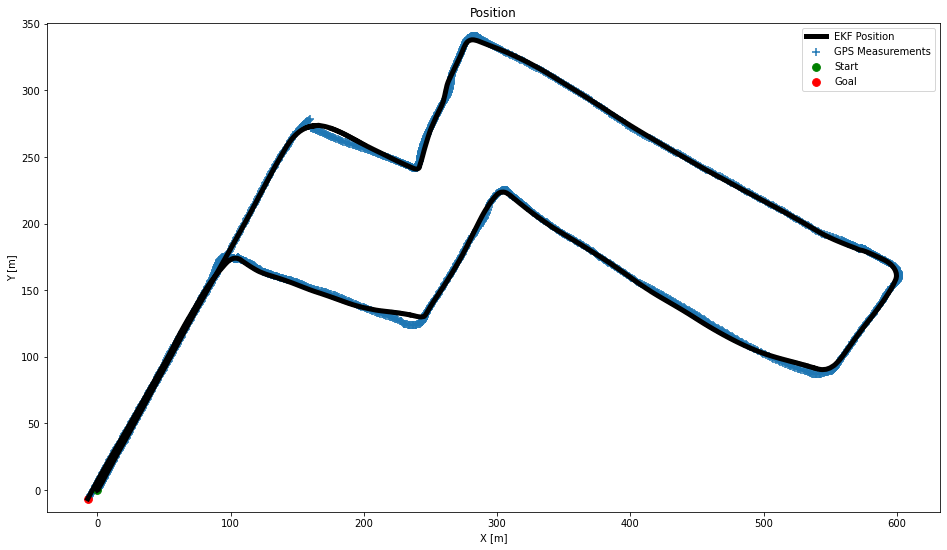

In [39]:
plotxy()

In [40]:
def plotxydetails():
    fig = plt.figure(figsize=(12,9))

    plt.subplot(221)
    # EKF State
    #plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', alpha=0.5, marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    plt.xlabel('X [m]')
    plt.xlim(70, 130)
    plt.ylabel('Y [m]')
    plt.ylim(140, 200)
    plt.title('Position')
    plt.legend(loc='best')


    plt.subplot(222)

    # EKF State
    #plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', alpha=0.5, marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    plt.xlabel('X [m]')
    plt.xlim(160, 260)
    plt.ylabel('Y [m]')
    plt.ylim(110, 160)
    plt.title('Position')
    plt.legend(loc='best')

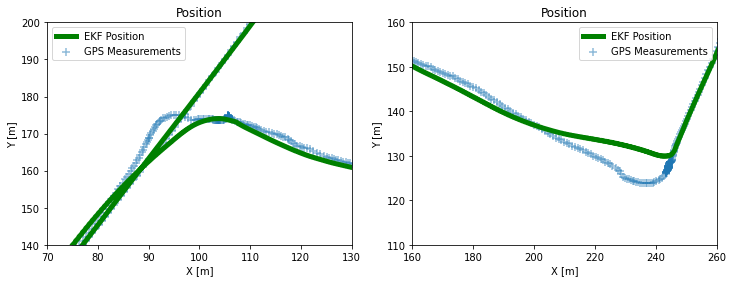

In [41]:
plotxydetails()